In [1]:
import base64
import json 
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from urllib.parse import urlparse
import boto3
from IPython.display import Image
from PIL import Image as ImageEdit
import urllib.request
import numpy as np
import os
import cv2
import s3fs
from matplotlib import pyplot as plt
from glob import glob 
role = get_execution_role()
import time
sagemaker_session = sage.Session()
fs = s3fs.S3FileSystem()

In [2]:
bucket=sagemaker_session.default_bucket()
bucket

'sagemaker-us-west-2-060183668755'

# Creating endpoint

In [3]:
real_time_inference_instance_type='ml.m4.xlarge'
content_type='image/jpeg'
model_package_arn='arn:aws:sagemaker:us-west-2:060183668755:model-package/ws-social-distancing-0-1'
endpoint_name='whs-distancing-demo'
region_name = 'us-west-2'
data_bucket_path = 's3://worker-safety-src-data-sagemaker/data/whs/demo_images'

In [4]:
def predict_wrapper(endpoint, session):
    return sage.RealTimePredictor(endpoint, session,content_type)
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

#Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=endpoint_name)

-------------------!

# Inferencing Model Endpoint

In [6]:
client = boto3.client('sagemaker-runtime', region_name=region_name)

In [7]:
def inference_image(client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        img_bytes = f.read()
    res = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='image/jpeg',
        Accept='application/json',
        Body=img_bytes)
    prediction = json.load(res['Body'])
    return prediction

In [9]:
inference_image(client, endpoint_name, 'data/whs-distancing-demo-images/images.jpeg')

{'people': {'person_0': [187, 7, 259, 160], 'person_1': [30, 2, 94, 157]},
 'social_distancing_violations': [],
 'violators': []}

# Show results

In [42]:
def visualize(img, annotation_d, alpha=0.5, font=1.0):
    people = annotation_d['people']
    violaters = annotation_d['violators']
    result_image = img.copy()
    for k, object_annotation in people.items():
        class_annot = 0 if int(k.replace('person_','')) in violaters else 1
        box = object_annotation
        start, end = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        color = (255,0,0) if  class_annot == 0 else (0,255,0)
        result_object = result_image.copy()
        result_object = cv2.rectangle(result_object, (start[0] , start[1]), end, color, -1 )
        cv2.addWeighted(result_object, alpha, result_image, 1 - alpha, 0, result_image)
    return result_image

def read_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [36]:
images_paths = glob('data/whs-distancing-demo-images/*.jpg')+glob('data/whs-distancing-demo-images/*.jpeg')
images = [read_image(path) for path in images_paths]

In [37]:
images_paths

['data/whs-distancing-demo-images/_112148911_hi061086198.jpg',
 'data/whs-distancing-demo-images/960x0.jpg',
 'data/whs-distancing-demo-images/0408560E-1722-4BA0-AD7C-3273D0EA0AFF_w1071_s.jpg',
 'data/whs-distancing-demo-images/here-comes-the-sun-blanket-paul-cocksedge-design_dezeen_2364_col_0.jpg',
 'data/whs-distancing-demo-images/1920_200316-covid19-social-distancing-banner.jpg',
 'data/whs-distancing-demo-images/images.jpeg',
 'data/whs-distancing-demo-images/download.jpeg']

In [38]:
predictions = []
for img_path in images_paths:
    predictions.append(inference_image(client, endpoint_name, img_path)) 

## Perfect social distancing 

(-0.5, 2363.5, 1575.5, -0.5)

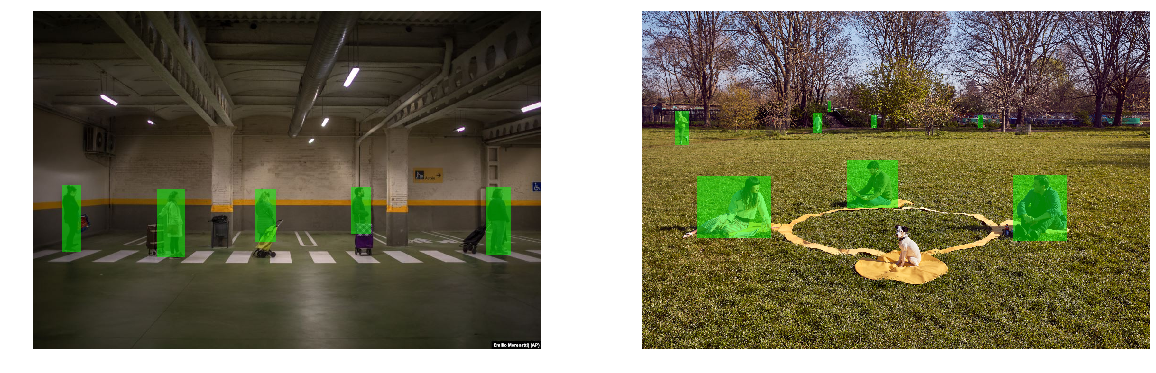

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 30))
res = visualize(images[2], predictions[2], 0.5)
axes[0].imshow(res)
axes[0].axis('off')
res = visualize(images[3], predictions[3], 0.5)
axes[1].imshow(res)
axes[1].axis('off')

## No social distancing

(-0.5, 639.5, 419.5, -0.5)

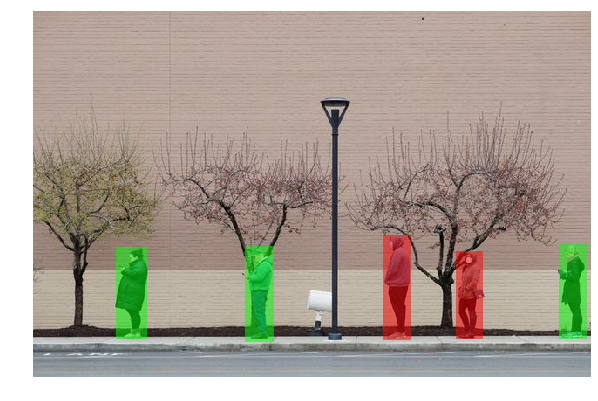

In [46]:
res = visualize(images[6], predictions[6], 0.5)
plt.figure(figsize=(10, 10))
plt.imshow(res)
plt.axis('off')

In [48]:
predictor.delete_model()

Exception: One or more models cannot be deleted, please retry. 
Failed models: ws-social-distancing-0-1-2020-07-06-07-05-11-474